In [7]:
# !pip install torch numpy matplotlib

In [51]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

画像ファイルを正常に読み込みました


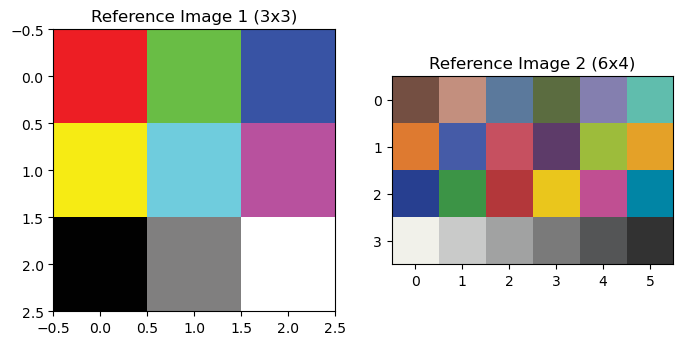

入力データ形状: (33, 3)
正解データ形状: (33, 3)


In [57]:
# 推論データ
X =  np.array([[0.99215686, 0.04705882, 0.05098039],
                [0.        , 0.98039216, 0.01568627],
                [0.        , 0.02745098, 1.        ],
                [0.94901961, 0.96078431, 0.00392157],
                [0.01176471, 0.89019608, 1.        ],
                [0.88235294, 0.03137255, 1.        ],
                [0.        , 0.        , 0.        ],
                [0.54509804, 0.50588235, 0.49019608],
                [0.99607843, 1.        , 0.99607843],

               [0.11, 0.04, 0.00],
               [0.41, 0.41, 0.19],
               [0.10, 0.29, 0.27],
               [0.05, 0.15, 0.03],
               [0.19, 0.35, 0.35],
               [0.25, 0.85, 0.44],

               [0.55, 0.29, 0.05],
               [0.05, 0.18, 0.30],
               [0.43, 0.13, 0.11],
               [0.05, 0.01, 0.08],
               [0.34, 0.80, 0.14],
               [0.66, 0.60, 0.12],

               [0.05, 0.08, 0.21],
               [0.08, 0.39, 0.06],
               [0.28, 0.00, 0.00],
               [0.63, 0.84, 0.11],
               [0.35, 0.10, 0.18],
               [0.06, 0.39, 0.34],

               [0.90, 1.00, 0.87],
               [0.56, 0.94, 0.55],
               [0.29, 0.49, 0.28],
               [0.12, 0.19, 0.11],
               [0.03, 0.05, 0.03],
               [0.00, 0.00, 0.00]], dtype=np.float32)

# 画像を読み込む（自分のPPMファイルのパスに変更してください）
try:
    # ここに実際のファイルパスを入力してください
    img1_path = "./img/reference_image1_cmyk_large.png"  # PPMファイル1
    img2_path = "./img/reference_image2_cmyk_large.png"  # PPMファイル2

    # PPMファイルを読み込み、適切なサイズにリサイズ
    img1 = cv2.resize(cv2.imread(img1_path, cv2.IMREAD_COLOR), (3,3), interpolation=cv2.INTER_NEAREST)
    img2 = cv2.resize(cv2.imread(img2_path, cv2.IMREAD_COLOR), (6,4), interpolation=cv2.INTER_NEAREST)
    
    # OpenCVはBGRで読み込むので、RGBに変換
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    print("画像ファイルを正常に読み込みました")
except Exception as e:
    print(f"画像ファイルが見つからないため、ダミーデータを作成します: {e}")
    # ダミー画像データを作成
    img1 = np.random.randint(0, 255, (3, 3, 3), dtype=np.uint8)
    img2 = np.random.randint(0, 255, (4, 6, 3), dtype=np.uint8)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title("Reference Image 1 (3x3)")
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title("Reference Image 2 (6x4)")
plt.show()

# 正解データ
Y = np.concatenate([img1.reshape([-1, 3])/255, img2.reshape([-1, 3])/255], axis=0).astype(np.float32)
print(f"入力データ形状: {X.shape}")
print(f"正解データ形状: {Y.shape}")

In [58]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# モデル定義
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 3),
        )

    def forward(self, x):
        return self.model(x)

model = ColorNet()

# 損失関数（MSE）
criterion = nn.MSELoss()

# 最適化手法
optimizer = optim.Adam(model.parameters(), lr=0.01)

# L1正則化の係数
lambda_l1 = 1e-6

# 学習ループ
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_tensor)
    mse = criterion(outputs, Y_tensor)

    # --- L1 正則化-----------------------------
    l1 = torch.tensor(0.0, requires_grad=False)
    for name, p in model.named_parameters():
        if 'weight' in name:
            l1 = l1 + p.abs().sum()
    loss = mse + lambda_l1 * l1
    # -----------------------------------------

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch [{epoch}/{epochs}]  MSE: {mse.item():.6f}  L1: {l1.item():.2f}  Loss: {loss.item():.6f}')

with torch.no_grad():
    predictions = model(X_tensor)
    print("\n予測結果：")
    print(predictions.numpy())

def convert_to_cpp_array(tensor: torch.Tensor, name: str, dtype: str = "float"):
    flat = tensor.detach().numpy().flatten()
    array_str = f"{dtype} {name}[] = {{"
    array_str += ", ".join(map(str, flat))
    array_str += "};"
    return array_str

cpp_code = ""

layer_idx = 1
for layer in model.model:
    if isinstance(layer, torch.nn.Linear):
        cpp_code += convert_to_cpp_array(layer.weight, f"weight_{layer_idx}") + "\n"
        cpp_code += convert_to_cpp_array(layer.bias,   f"bias_{layer_idx}") + "\n"
        layer_idx += 1

with open("model_parameters.h", "w") as f:
    f.write(cpp_code)

print("\nC++ 用のパラメータファイル (model_parameters.h) を作成しました。")


Epoch [0/50000]  MSE: 0.313501  L1: 175.54  Loss: 0.313676
Epoch [500/50000]  MSE: 0.001124  L1: 167.25  Loss: 0.001292
Epoch [1000/50000]  MSE: 0.000966  L1: 162.57  Loss: 0.001129
Epoch [1500/50000]  MSE: 0.000726  L1: 159.42  Loss: 0.000886
Epoch [2000/50000]  MSE: 0.000652  L1: 154.94  Loss: 0.000807
Epoch [2500/50000]  MSE: 0.000603  L1: 152.01  Loss: 0.000755
Epoch [3000/50000]  MSE: 0.000590  L1: 146.58  Loss: 0.000737
Epoch [3500/50000]  MSE: 0.000652  L1: 141.34  Loss: 0.000793
Epoch [4000/50000]  MSE: 0.000568  L1: 136.06  Loss: 0.000704
Epoch [4500/50000]  MSE: 0.000572  L1: 130.51  Loss: 0.000703
Epoch [5000/50000]  MSE: 0.000608  L1: 125.66  Loss: 0.000734
Epoch [5500/50000]  MSE: 0.000577  L1: 121.18  Loss: 0.000698
Epoch [6000/50000]  MSE: 0.000614  L1: 116.91  Loss: 0.000731
Epoch [6500/50000]  MSE: 0.000600  L1: 113.46  Loss: 0.000714
Epoch [7000/50000]  MSE: 0.000604  L1: 108.42  Loss: 0.000712
Epoch [7500/50000]  MSE: 0.000569  L1: 104.65  Loss: 0.000674
Epoch [8000/

In [55]:
# カンマ区切りなしの数値を自動的に処理するセル
# 以下の raw_input に27個の数値をスペース区切りまたは改行区切りで貼り付けてください

raw_input = """
253 12 13 0 250  4 0 7 255 
242 245 1 3 227 255 225 8 255 
0 0 0 139 129 125 254 255 254
"""

# 自動処理：文字列から数値リストを抽出
import re
import numpy as np

# 数値のみを抽出（スペース、改行、タブで区切られた数値を取得）
numbers = re.findall(r'\d+', raw_input)
data = [int(num) for num in numbers]

print(f"抽出された数値: {len(data)}個")
print(f"数値リスト: {data}")

# 27個の数値が正しく抽出されたかチェック
if len(data) == 27:
    print("✓ 正確に27個の数値が抽出されました")
    
    # RGB グループに自動分割
    rgb_groups = np.array(data).reshape(-1, 3)
    print("\nRGBグループ:")
    print(rgb_groups)
    
    # 0-1の範囲に正規化
    rgb_normalized = rgb_groups / 255.0
    print("\n正規化されたRGB値（0-1範囲）:")
    print(rgb_normalized)
    
    # X配列として出力（コピペ用）
    print("\n以下を3番目のセルのX配列として使用してください:")
    print("X = np.array([")
    for i, rgb in enumerate(rgb_normalized):
        if i == len(rgb_normalized) - 1:
            print(f"    [{rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f}]")
        else:
            print(f"    [{rgb[0]:.3f}, {rgb[1]:.3f}, {rgb[2]:.3f}],")
    print("], dtype=np.float32)")
    
else:
    print(f"❌ エラー: {len(data)}個の数値が見つかりました（27個必要）")
    print("数値を確認して再度貼り付けてください")

抽出された数値: 27個
数値リスト: [253, 12, 13, 0, 250, 4, 0, 7, 255, 242, 245, 1, 3, 227, 255, 225, 8, 255, 0, 0, 0, 139, 129, 125, 254, 255, 254]
✓ 正確に27個の数値が抽出されました

RGBグループ:
[[253  12  13]
 [  0 250   4]
 [  0   7 255]
 [242 245   1]
 [  3 227 255]
 [225   8 255]
 [  0   0   0]
 [139 129 125]
 [254 255 254]]

正規化されたRGB値（0-1範囲）:
[[0.99215686 0.04705882 0.05098039]
 [0.         0.98039216 0.01568627]
 [0.         0.02745098 1.        ]
 [0.94901961 0.96078431 0.00392157]
 [0.01176471 0.89019608 1.        ]
 [0.88235294 0.03137255 1.        ]
 [0.         0.         0.        ]
 [0.54509804 0.50588235 0.49019608]
 [0.99607843 1.         0.99607843]]

以下を3番目のセルのX配列として使用してください:
X = np.array([
    [0.992, 0.047, 0.051],
    [0.000, 0.980, 0.016],
    [0.000, 0.027, 1.000],
    [0.949, 0.961, 0.004],
    [0.012, 0.890, 1.000],
    [0.882, 0.031, 1.000],
    [0.000, 0.000, 0.000],
    [0.545, 0.506, 0.490],
    [0.996, 1.000, 0.996]
], dtype=np.float32)


# 自分のデータに書き換える方法

## 1. 入力データ（X）の書き換え
- `X`配列は、あなたのArduinoカラースキャナーで測定した実際のRGB値に置き換えてください
- 各値は0-1の範囲で正規化してください（255で割ると良い）
- データ数は33個（3x3 + 6x4 = 9 + 24 = 33）に合わせてください

## 2. 正解データ（Y）の書き換え
- 上記のセルの`img1_path`と`img2_path`を、あなたの正解画像ファイルのパスに変更してください
- PPMファイルまたは通常の画像ファイル（PNG、JPGなど）が使用できます

## 3. ファイルパスの例
```python
img1_path = "../lecture1/result.ppm"        # 3x3の正解画像
img2_path = "../lecture1/rev_result1.ppm"   # 6x4の正解画像
```

## 4. データ数の調整
入力データ（X）と正解データ（Y）のサンプル数が一致している必要があります。